In [1]:
import json
import urllib

import httpx
import time
import requests
import textwrap

import pandas as pd
import numpy as np
import sys

from api_key import WOS_API_KEY

from requests import Session

from pprint import pprint

import sys 
import re
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sentence_transformers import SentenceTransformer
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
from bertopic.backend import WordDocEmbedder

import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import WordEmbeddingSimilarityIndex
from bertopic import BERTopic

from re import sub
from multiprocessing import cpu_count

from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity

from xgboost import XGBClassifier
import argparse
from keybert import KeyBERT
from sklearn.metrics.pairwise import cosine_similarity

from autocorrect import Speller
import tldextract

from itertools import combinations
from nltk import skipgrams
import umap

import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib as mpl
from pylab import rcParams
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_theme(style='white')
#% matplotlib inline
from datetime import datetime

import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.express as px
from plotly import tools
from plotly.subplots import make_subplots
from plotly.offline import iplot

from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger
from bertopic.vectorizers import ClassTfidfTransformer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
nltk.download('maxent_ne_chunker')
nltk.download('words')

import spacy
nlp = spacy.load('en_core_web_sm')

from gensim.models import word2vec
import pickle
import gzip
import argparse
import torch
from transformers import BertTokenizer, BertModel
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import PartOfSpeech


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
'''
# Sending the initial request
SEARCH_QUERY = 'TS=((misogyn* OR sexis* OR (gender NEAR/3 discrim*)) NEAR/3 (detect* OR identif* OR predict* OR classif*)) AND PY=2012-2022'
HEADERS = {'X-APIkey': WOS_API_KEY}
DATABASE_ID = 'WOS' # Not using WOK

test_request = requests.get(f'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&'
                            f'count=0&firstRecord=1', headers=HEADERS)
data = test_request.json()

total_documents_found = data['QueryResult']['RecordsFound']
requests_required = ((total_documents_found - 1) // 100 ) + 1
for i in range(0, requests_required):
    request = requests.get(f'https://api.clarivate.com/api/wos?databaseId=WOS&usrQuery={SEARCH_QUERY}&'
                                      f'count=100&firstRecord={i}01', headers=HEADERS)
    data = request.json()
    results = data['Data']['Records']['records']['REC']
    with open(f'data/collected/adv_search/searches_adv_{i}.json', "w") as outfile:
        json.dump(results, outfile)

    #for wos_record in data['Data']['Records']['records']['REC']:
        #print(f"Document ID: {wos_record['UID']}")
        #print(wos_record)

'''

'\n# Sending the initial request\nSEARCH_QUERY = \'TS=((misogyn* OR sexis* OR (gender NEAR/3 discrim*)) NEAR/3 (detect* OR identif* OR predict* OR classif*)) AND PY=2012-2022\'\nHEADERS = {\'X-APIkey\': WOS_API_KEY}\nDATABASE_ID = \'WOS\' # Not using WOK\n\ntest_request = requests.get(f\'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&\'\n                            f\'count=0&firstRecord=1\', headers=HEADERS)\ndata = test_request.json()\n\ntotal_documents_found = data[\'QueryResult\'][\'RecordsFound\']\nrequests_required = ((total_documents_found - 1) // 100 ) + 1\nfor i in range(0, requests_required):\n    request = requests.get(f\'https://api.clarivate.com/api/wos?databaseId=WOS&usrQuery={SEARCH_QUERY}&\'\n                                      f\'count=100&firstRecord={i}01\', headers=HEADERS)\n    data = request.json()\n    results = data[\'Data\'][\'Records\'][\'records\'][\'REC\']\n    with open(f\'data/collected/adv_search/searches_adv_{i}.json

In [3]:
files= []

# For the above search query
string1 = 'data/collected/adv_search/searches_adv_' 
string2 = '.json'

for i in range(0, 5):  
    files.append(string1 + str(i) + string2)

In [4]:
data = pd.DataFrame()

for lst in files:
    with open(lst, 'r') as f:
        data_temp = json.load(f)
    data_temp = pd.json_normalize(data_temp)
    data = pd.concat([data, data_temp], axis=0)  

data = data.reset_index(drop=True)

In [5]:
data['index'] = data.index
data.columns

Index(['UID', 'r_id_disclaimer', 'static_data.summary.pub_info.coverdate',
       'static_data.summary.pub_info.vol',
       'static_data.summary.pub_info.journal_oas_gold',
       'static_data.summary.pub_info.has_citation_context',
       'static_data.summary.pub_info.pubyear',
       'static_data.summary.pub_info.sortdate',
       'static_data.summary.pub_info.has_abstract',
       'static_data.summary.pub_info.pubmonth',
       ...
       'static_data.fullrecord_metadata.addresses.address_name.names.name.noncore_endyear',
       'static_data.fullrecord_metadata.addresses.address_name.names.name.orcid_id',
       'static_data.fullrecord_metadata.addresses.address_name.names.name.noncore_startyear',
       'static_data.fullrecord_metadata.addresses.address_name.names.name.preferred_name.middle_name',
       'static_data.fullrecord_metadata.fund_ack.grants.grant.grant_source',
       'static_data.summary.names.name.data-item-ids.data-item-id',
       'static_data.fullrecord_metadata.a

In [6]:
data['static_data.summary.pub_info.pubtype'].unique()

array(['Journal', 'Book in series', 'Book'], dtype=object)

In [7]:
titles_df = pd.json_normalize(data['static_data.summary.titles.title'])
titles_df

,0,1,2,3,4,5,6
0,"{'type': 'source', 'content': 'FRONTIERS IN PO...","{'type': 'source_abbrev', 'content': 'FRONT PO...","{'type': 'abbrev_iso', 'content': 'Front. Poli...","{'type': 'abbrev_11', 'content': 'FRO POL SCI'}","{'type': 'abbrev_29', 'content': 'FRONT POLIT ...","{'type': 'item', 'content': 'Who perceives wom...",None
1,"{'type': 'source', 'content': 'PSICOLOGIA SOCI...","{'type': 'source_abbrev', 'content': 'PSICOLOG...","{'type': 'abbrev_iso', 'content': 'Psicolog. S...","{'type': 'abbrev_11', 'content': 'PSICOLO SOC'}","{'type': 'abbrev_29', 'content': 'PSICOLOG SOC'}","{'type': 'item', 'content': 'Strongly identify...",None
2,"{'type': 'source', 'content': 'CUKUROVA UNIVER...","{'type': 'source_abbrev', 'content': 'CUKUROVA...","{'type': 'abbrev_iso', 'content': 'Cukurova Un...","{'type': 'abbrev_11', 'content': 'CUK U FAC E'}","{'type': 'abbrev_29', 'content': 'CUKUROVA UNI...","{'type': 'item', 'content': 'An Investigation ...",None
3,"{'type': 'source', 'content': 'CUKUROVA UNIVER...","{'type': 'source_abbrev', 'content': 'CUKUROVA...","{'type': 'abbrev_iso', 'content': 'Cukurova Un...","{'type': 'abbrev_11', 'content': 'CUK U FAC E'}","{'type': 'abbrev_29', 'content': 'CUKUROVA UNI...","{'type': 'item', 'content': 'Examining the Rel...",None
4,"{'type': 'source', 'content': '2022 13TH INTER...","{'type': 'series', 'content': 'International C...","{'type': 'source_abbrev', 'content': 'INT CONF...","{'type': 'abbrev_11', 'content': 'INT C INFOR'}","{'type': 'abbrev_29', 'content': 'INT CONF INF...","{'type': 'item', 'content': 'Should Course-bas...","{'translated': 'N', 'type': 'book_series', 'co..."
...,...,...,...,...,...,...,...
398,"{'type': 'source', 'content': 'ANALES DE PSICO...","{'type': 'source_abbrev', 'content': 'AN PSICO...","{'type': 'abbrev_iso', 'content': 'An. Psicol.'}","{'type': 'abbrev_11', 'content': 'AN PSICOL'}","{'type': 'abbrev_29', 'content': 'AN PSICOL'}","{'type': 'item', 'content': 'Perception of bat...",None
399,"{'type': 'source', 'content': 'EUROPEAN JOURNA...","{'type': 'source_abbrev', 'content': 'EUR J SO...","{'type': 'abbrev_iso', 'content': 'Eur. J. Soc...","{'type': 'abbrev_11', 'content': 'EUR J SOC P'}","{'type': 'abbrev_29', 'content': 'EUR J SOC PS...","{'type': 'item', 'content': 'Communality sells...",None
400,"{'type': 'source', 'content': 'JOURNAL OF APPL...","{'type': 'source_abbrev', 'content': 'J APPL S...","{'type': 'abbrev_iso', 'content': 'J. Appl. So...","{'type': 'abbrev_11', 'content': 'J APPL SO P'}","{'type': 'abbrev_29', 'content': 'J APPL SOC P...","{'type': 'item', 'content': 'When Benevolence ...",None
401,"{'type': 'source', 'content': 'JOURNAL OF BLAC...","{'type': 'source_abbrev', 'content': 'J BLACK ...","{'type': 'abbrev_iso', 'content': 'J. Black St...","{'type': 'abbrev_11', 'content': 'J BLACK ST'}","{'type': 'abbrev_29', 'content': 'J BLACK STUD'}","{'type': 'item', 'content': 'Black Women Talk ...",None


In [8]:
titles_df.describe()

,0,1,2,3,4,5,6
count,403,403,379,378,378,378,17
unique,262,258,235,233,234,378,12
top,"{'type': 'source', 'content': 'SEX ROLES'}","{'type': 'source_abbrev', 'content': 'SEX ROLES'}","{'type': 'abbrev_iso', 'content': 'Sex Roles'}","{'type': 'abbrev_11', 'content': 'SEX ROLES'}","{'type': 'abbrev_29', 'content': 'SEX ROLES'}","{'type': 'item', 'content': 'Who perceives wom...","{'translated': 'N', 'type': 'book_series', 'co..."
freq,31,31,31,31,31,1,4


In [9]:
# Source of the title
titles_0_df = pd.json_normalize(titles_df[0])
titles_0_df

,type,content
0,source,FRONTIERS IN POLITICAL SCIENCE
1,source,PSICOLOGIA SOCIALE
2,source,CUKUROVA UNIVERSITY FACULTY OF EDUCATION JOURNAL
3,source,CUKUROVA UNIVERSITY FACULTY OF EDUCATION JOURNAL
4,source,2022 13TH INTERNATIONAL CONFERENCE ON INFORMAT...
...,...,...
398,source,ANALES DE PSICOLOGIA
399,source,EUROPEAN JOURNAL OF SOCIAL PSYCHOLOGY
400,source,JOURNAL OF APPLIED SOCIAL PSYCHOLOGY
401,source,JOURNAL OF BLACK STUDIES


In [10]:
titles_0_df['content'].isna().sum()

0

In [11]:
# Title of the content
titles_5_df = pd.json_normalize(titles_df[5])
titles_5_df

,type,content
0,item,Who perceives women's rights as threatening to...
1,item,Strongly identifying Italian women support the...
2,item,An Investigation of Marriage Attitude in terms...
3,item,Examining the Relationship Between Maternal Em...
4,item,Should Course-based At-risk Predication Models...
...,...,...
398,item,Perception of battered women on power asymmetr...
399,item,Communality sells: The impact of perceivers' s...
400,item,When Benevolence Backfires: Benevolent Sexists...
401,item,Black Women Talk About Workplace Stress and Ho...


In [12]:
cols = data.columns.to_list()

with open(r'list_columns.txt', 'w') as fp:
    fp.write('\n'.join(cols))

In [13]:
#abstract_df = data[['static_data.fullrecord_metadata.abstracts.abstract.abstract_text.p', 'index']]
#abstract_df = abstract_df.reset_index()
#abstract_df

In [14]:
abstract_count_df = data['static_data.fullrecord_metadata.abstracts.abstract.abstract_text.count']
abstract_count_df.value_counts()

1.0    374
2.0      7
4.0      7
5.0      3
3.0      3
8.0      1
6.0      1
Name: static_data.fullrecord_metadata.abstracts.abstract.abstract_text.count, dtype: int64

In [15]:
abstract_count = data['static_data.fullrecord_metadata.abstracts.count']
abstract_count.unique()

array([ 1., nan])

In [16]:
data['static_data.summary.pub_info.has_abstract'].value_counts()

Y    396
N      7
Name: static_data.summary.pub_info.has_abstract, dtype: int64

In [19]:
data = data[data['static_data.summary.pub_info.has_abstract'] == 'Y']
data

,UID,r_id_disclaimer,static_data.summary.pub_info.coverdate,static_data.summary.pub_info.vol,static_data.summary.pub_info.journal_oas_gold,static_data.summary.pub_info.has_citation_context,static_data.summary.pub_info.pubyear,static_data.summary.pub_info.sortdate,static_data.summary.pub_info.has_abstract,static_data.summary.pub_info.pubmonth,...,static_data.fullrecord_metadata.addresses.address_name.names.name.noncore_endyear,static_data.fullrecord_metadata.addresses.address_name.names.name.orcid_id,static_data.fullrecord_metadata.addresses.address_name.names.name.noncore_startyear,static_data.fullrecord_metadata.addresses.address_name.names.name.preferred_name.middle_name,static_data.fullrecord_metadata.fund_ack.grants.grant.grant_source,static_data.summary.names.name.data-item-ids.data-item-id,static_data.fullrecord_metadata.addresses.address_name.names.name.data-item-ids.data-item-id,static_data.fullrecord_metadata.reprint_addresses.address_name.names.name,static_data.summary.pub_info.part_no,index
0,WOS:000993557000001,ResearcherID data provided by Clarivate Analytics,AUG 15 2022,4.0,Y,Y,2022,2022-08-15,Y,AUG 15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,WOS:000975433600006,ResearcherID data provided by Clarivate Analytics,SEP-DEC 2022,17.0,N,NaN,2022,2022-09-01,Y,SEP-DEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,WOS:000960862300008,ResearcherID data provided by Clarivate Analytics,DEC 2022,51.0,Y,NaN,2022,2022-12-01,Y,DEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,WOS:000960862300009,ResearcherID data provided by Clarivate Analytics,DEC 2022,51.0,Y,NaN,2022,2022-12-01,Y,DEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,WOS:000937676000047,ResearcherID data provided by Clarivate Analytics,2022,NaN,N,NaN,2022,2022-01-01,Y,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,WOS:000302204000011,ResearcherID data provided by Clarivate Analytics,MAY 2012,28.0,Y,NaN,2012,2012-05-01,Y,MAY,...,2023.0,0000-0003-2365-3779,1992.0,L.,NaN,NaN,NaN,NaN,NaN,398
399,WOS:000300692800010,ResearcherID data provided by Clarivate Analytics,MAR 2012,42.0,N,NaN,2012,2012-03-01,Y,MAR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,399
400,WOS:000300428700002,ResearcherID data provided by Clarivate Analytics,FEB 2012,42.0,N,NaN,2012,2012-02-01,Y,FEB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400
401,WOS:000300052900006,ResearcherID data provided by Clarivate Analytics,MAR 2012,43.0,N,NaN,2012,2012-03-01,Y,MAR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,401


In [20]:
data['static_data.summary.pub_info.early_access_year'].unique()

array([  nan, 2022., 2021., 2020., 2019.])

In [21]:
data['static_data.summary.pub_info.early_access_date'].unique()

array([nan, 'DEC 2022', 'OCT 2022', 'NOV 2022', 'SEP 2022', 'AUG 2022',
       'JUL 2022', 'MAY 2022', 'APR 2021', 'MAR 2022', 'APR 2022',
       'FEB 2022', 'JAN 2022', 'JAN 2021', 'DEC 2021', 'NOV 2021',
       'OCT 2021', 'SEP 2021', 'MAY 2021', 'JUL 2021', 'AUG 2021',
       'JUN 2021', 'FEB 2021', 'MAR 2021', 'DEC 2020', 'NOV 2020',
       'OCT 2020', 'SEP 2020', 'AUG 2020', 'JUL 2020', 'JUN 2020',
       'APR 2020', 'MAR 2020', 'FEB 2020', 'JAN 2020', 'DEC 2019',
       'AUG 2019', 'JUN 2019', 'JUL 2019'], dtype=object)

In [22]:
data['static_data.summary.pub_info.pubyear'].unique()

array([2022, 2023, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013,
       2012])

In [23]:
data['static_data.summary.names.name']

0      [{'seq_no': 1, 'role': 'author', 'claim_status...
1      [{'seq_no': 1, 'role': 'author', 'claim_status...
2      [{'seq_no': 1, 'role': 'author', 'claim_status...
3      [{'seq_no': 1, 'role': 'author', 'claim_status...
4      [{'seq_no': 1, 'role': 'author', 'claim_status...
                             ...                        
398    [{'seq_no': 1, 'role': 'author', 'claim_status...
399    [{'seq_no': 1, 'role': 'author', 'claim_status...
400    [{'seq_no': 1, 'role': 'author', 'claim_status...
401    [{'seq_no': 1, 'role': 'author', 'claim_status...
402    [{'seq_no': 1, 'role': 'author', 'claim_status...
Name: static_data.summary.names.name, Length: 396, dtype: object

In [24]:
data['static_data.summary.publishers.publisher.names.name.full_name']

0                 FRONTIERS MEDIA SA
1                   SOC ED IL MULINO
2                      CUKUROVA UNIV
3                      CUKUROVA UNIV
4                               IEEE
                   ...              
398                      UNIV MURCIA
399                            WILEY
400                            WILEY
401            SAGE PUBLICATIONS INC
402    PERGAMON-ELSEVIER SCIENCE LTD
Name: static_data.summary.publishers.publisher.names.name.full_name, Length: 396, dtype: object

In [25]:
data['static_data.fullrecord_metadata.addresses.address_name.names.name']

0      [{'seq_no': 1, 'role': 'author', 'claim_status...
1                                                    NaN
2                                                    NaN
3                                                    NaN
4                                                    NaN
                             ...                        
398                                                  NaN
399                                                  NaN
400                                                  NaN
401                                                  NaN
402                                                  NaN
Name: static_data.fullrecord_metadata.addresses.address_name.names.name, Length: 396, dtype: object

In [26]:
data['static_data.fullrecord_metadata.reprint_addresses.address_name.names.name.full_name']

0             Off, Gefjon
1          Caricati, Luca
2          Dombak, Kuebra
3           Bozkur, Binaz
4      Jawthari, Moohanad
              ...        
398      Megias, Jesus L.
399     Infanger, Martina
400        Osborne, Danny
401      Hall, J. Camille
402        Moreno, Martin
Name: static_data.fullrecord_metadata.reprint_addresses.address_name.names.name.full_name, Length: 396, dtype: object

In [27]:
check = data['static_data.fullrecord_metadata.reprint_addresses.address_name.names.name.full_name'].apply(lambda x: len(str(x).split(', ')))
check.unique()

array([2, 1])

In [28]:
data['static_data.fullrecord_metadata.reprint_addresses.address_name.names.name.first_name']

0          Gefjon
1            Luca
2          Kuebra
3           Binaz
4        Moohanad
          ...    
398      Jesus L.
399       Martina
400         Danny
401    J. Camille
402        Martin
Name: static_data.fullrecord_metadata.reprint_addresses.address_name.names.name.first_name, Length: 396, dtype: object

In [29]:
data['static_data.fullrecord_metadata.addresses.address_name.names.name.display_name']

0                   NaN
1                   NaN
2                   NaN
3                   NaN
4                   NaN
             ...       
398    Megias, Jesus L.
399                 NaN
400                 NaN
401                 NaN
402                 NaN
Name: static_data.fullrecord_metadata.addresses.address_name.names.name.display_name, Length: 396, dtype: object

In [30]:
df_authors = pd.DataFrame.from_dict(data['static_data.summary.names.name'].explode())
df_authors['index'] = df_authors.index
df_auth_temp = pd.json_normalize(df_authors['static_data.summary.names.name']).set_index(df_authors.index)
#df_auth_temp['temp_index'] = df_auth_temp.index

df_authors = pd.concat([df_authors, df_auth_temp], axis='columns')
df_authors = df_authors.drop(columns=['static_data.summary.names.name'])
df_authors.columns

Index(['index', 'seq_no', 'role', 'claim_status', 'reprint', 'last_name',
       'display_name', 'daisng_id', 'full_name', 'addr_no', 'wos_standard',
       'r_id', 'first_name', 'data-item-ids.data-item-id.type',
       'data-item-ids.data-item-id.content',
       'data-item-ids.data-item-id.id-type', 'preferred_name.full_name',
       'preferred_name.last_name', 'preferred_name.first_name', 'orcid_id',
       'noncore_endyear', 'noncore_startyear', 'preferred_name.middle_name',
       'data-item-ids.data-item-id', 'suffix'],
      dtype='object')

In [31]:
df_authors[['data-item-ids.data-item-id.type',
       'data-item-ids.data-item-id.content',
       'data-item-ids.data-item-id.id-type']]

,data-item-ids.data-item-id.type,data-item-ids.data-item-id.content,data-item-ids.data-item-id.id-type
0,person,GND-9795-2022,PreferredRID
0,person,GDX-2107-2022,PreferredRID
0,person,CBB-3855-2022,PreferredRID
1,person,AAI-5232-2021,PreferredRID
1,person,CQY-0139-2022,PreferredRID
...,...,...,...
401,person,CTF-2710-2022,PreferredRID
402,person,FYP-1158-2022,PreferredRID
402,person,GCL-0950-2022,PreferredRID
402,person,DPV-8892-2022,PreferredRID


In [32]:
# Publication year
data['pub_year'] = np.where(data['static_data.summary.pub_info.early_access_year'].isnull(), data['static_data.summary.pub_info.pubyear'], data['static_data.summary.pub_info.early_access_year'])
data['pub_year'].unique()

array([2022., 2021., 2020., 2019., 2018., 2017., 2016., 2015., 2014.,
       2013., 2012.])

<AxesSubplot:>

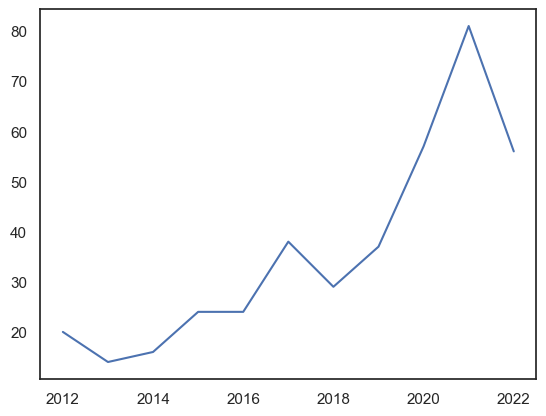

In [33]:
data['pub_year'].value_counts().sort_index().plot()

In [57]:
df_subjects = data['static_data.fullrecord_metadata.category_info.subjects.subject'].explode().reset_index(name='subjects')
df_subjects['temporary_index'] = df_subjects.index
df_subjects_temp = pd.json_normalize(df_subjects['subjects'])
df_subjects_temp['temporary_index'] = df_subjects_temp.index
df_subjects_temp['index'] = df_subjects_temp['temporary_index'].map(df_subjects.set_index('temporary_index')['index'])

df_subjects_temp

,ascatype,code,content,temporary_index,index
0,traditional,OE,International Relations,0,0
1,traditional,UU,Political Science,1,0
2,extended,NaN,International Relations,2,0
3,extended,NaN,Government & Law,3,0
4,traditional,WQ,"Psychology, Social",4,1
...,...,...,...,...,...
1258,extended,NaN,Social Sciences - Other Topics,1258,401
1259,traditional,DP,Development Studies,1259,402
1260,traditional,GY,Economics,1260,402
1261,extended,NaN,Development Studies,1261,402


In [102]:
#df_subjects_temp = df_subjects_temp.groupby(['ascatype', 'index', 'code']).apply(lambda a: a[:])

df_subjects_temp_trad = df_subjects_temp[df_subjects_temp['ascatype'] == 'traditional']
df_subjects_temp_ext = df_subjects_temp[df_subjects_temp['ascatype'] == 'extended']

df_subjects_temp_trad = df_subjects_temp_trad.groupby(['index'], as_index=False).agg({'content': ', '.join})
df_subjects_temp_ext = df_subjects_temp_ext.groupby(['index'], as_index=False).agg({'content': ', '.join})


In [103]:
df_subjects_temp_ext

,index,content
0,0,"International Relations, Government & Law"
1,1,Psychology
2,2,Education & Educational Research
3,3,Education & Educational Research
4,4,"Computer Science, Engineering, Telecommunications"
...,...,...
390,398,Psychology
391,399,Psychology
392,400,Psychology
393,401,"Ethnic Studies, Social Sciences - Other Topics"


In [32]:
data['static_data.summary.pub_info.journal_oas_gold'].unique()

array(['Y', 'N'], dtype=object)

In [33]:
data['static_data.summary.names.name.preferred_name.full_name']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
398    NaN
399    NaN
400    NaN
401    NaN
402    NaN
Name: static_data.summary.names.name.preferred_name.full_name, Length: 396, dtype: object

In [34]:
data['static_data.fullrecord_metadata.reprint_addresses.address_name.names.name']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
398    NaN
399    NaN
400    NaN
401    NaN
402    NaN
Name: static_data.fullrecord_metadata.reprint_addresses.address_name.names.name, Length: 396, dtype: object

In [35]:
data['static_data.summary.names.name.data-item-ids.data-item-id.content'].unique()

array([nan, 'HHV-1931-2022', 'AAP-8989-2020', 'GMI-9497-2022',
       'ABE-1883-2020', 'AAZ-2767-2020', 'FWD-1885-2022', 'DYS-2039-2022',
       'DTY-0387-2022', 'EEM-9049-2022', 'GCC-7571-2022', 'DWI-4272-2022',
       'FZX-4161-2022', 'G-9568-2014', 'CSM-0992-2022', 'FRI-8406-2022',
       'CEV-3916-2022', 'EWI-9019-2022', 'FCT-4008-2022', 'H-2798-2019',
       'EPY-2504-2022', 'ABA-7468-2020', 'CRP-1418-2022', 'J-7954-2019',
       'DVP-8960-2022', 'DWR-1699-2022', 'IOL-9710-2023', 'FTR-1823-2022',
       'DVN-0074-2022', 'CVP-9200-2022', 'CPK-0089-2022', 'FKV-9691-2022',
       'GGG-8048-2022', 'DWZ-6908-2022', 'FZX-2196-2022'], dtype=object)

In [36]:
data['static_data.summary.conferences.conference.conf_titles.conf_title'].value_counts().reset_index()

,index,static_data.summary.conferences.conference.conf_titles.conf_title
0,13th International Conference on Language Reso...,3
1,60th Annual Meeting of the Association-for-Com...,2
2,5th Workshop on Structured Prediction for NLP ...,2
3,Joint Conference of 59th Annual Meeting of the...,2
4,13th International Conference on Information a...,1
5,11th World Conference on Educational Sciences ...,1
6,"Conference on Signal Processing, Sensor/Inform...",1
7,44th IEEE International Conference on Acoustic...,1
8,International Conference on Cyber Situational ...,1
9,Conference on Empirical Methods in Natural Lan...,1


In [37]:
data['static_data.item.book_desc.bk_publisher'].unique()

array([nan,
       'IEEE SERVICE CENTER, 445 HOES LANE, PO BOX 1331, PISCATAWAY, NJ 08855-1331 USA',
       'EUROPEAN LANGUAGE RESOURCES ASSOC-ELRA, 55-57, RUE BRILLAT-SAVARIN, PARIS, 75013, FRANCE',
       'ASSOC COMPUTATIONAL LINGUISTICS-ACL, 209 N EIGHTH STREET, STROUDSBURG, PA 18360 USA',
       'ASSOC COMPUTING MACHINERY, P O BOX 64145, BALTIMORE, MD 21264 USA',
       'SPIE-INT SOC OPTICAL ENGINEERING, PO BOX 10, BELLINGHAM, WA 98227-0010 USA',
       'SCIENCEPARK SCI, ORGANIZATION & COUNSELING LTD, 13 SUBAT ST, NO 17, KYRENIA, 99030, CYPRUS',
       'MEDIMOND S R L, VIA MASERATI 5, 40128 BOLOGNA, 00000, ITALY'],
      dtype=object)

In [38]:
data['dates.date_created']

0      2023-06-02T09:37:17.841564
1      2023-05-14T11:09:03.197805
2      2023-04-29T13:42:07.294956
3      2023-04-29T13:42:07.294956
4      2023-03-15T02:29:05.877108
                  ...            
398    2012-12-25T12:25:20.684325
399    2012-12-25T12:25:20.684325
400    2012-12-25T12:25:20.684325
401    2012-12-25T12:25:20.684325
402    2012-12-25T12:25:20.684325
Name: dates.date_created, Length: 396, dtype: object

In [39]:
data['static_data.contributors.contributor']

0                                                    NaN
1                                                    NaN
2                                                    NaN
3                                                    NaN
4                                                    NaN
                             ...                        
398    [{'name': {'seq_no': 1, 'orcid_id': '0000-0003...
399                                                  NaN
400    [{'name': {'seq_no': 1, 'role': 'researcher_id...
401                                                  NaN
402    [{'name': {'seq_no': 1, 'orcid_id': '0000-0002...
Name: static_data.contributors.contributor, Length: 396, dtype: object

In [40]:
df_authors

,index,seq_no,role,claim_status,reprint,last_name,display_name,daisng_id,full_name,addr_no,...,data-item-ids.data-item-id.id-type,preferred_name.full_name,preferred_name.last_name,preferred_name.first_name,orcid_id,noncore_endyear,noncore_startyear,preferred_name.middle_name,data-item-ids.data-item-id,suffix
0,0,1.0,author,False,Y,Off,"Off, Gefjon",32180030.0,"Off, Gefjon",1,...,PreferredRID,"Off, Gefjon",Off,Gefjon,NaN,NaN,NaN,NaN,NaN,NaN
0,0,2.0,author,False,NaN,Charron,"Charron, Nicholas",29922492.0,"Charron, Nicholas",1,...,PreferredRID,"Charron, Nicholas",Charron,Nicholas,0000-0003-1386-0782,NaN,NaN,NaN,NaN,NaN
0,0,3.0,author,False,NaN,Alexander,"Alexander, Amy",4074271.0,"Alexander, Amy",1,...,PreferredRID,"Alexander, Amy",Alexander,Amy,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,author,True,Y,Caricati,"Caricati, Luca",462295.0,"Caricati, Luca",1,...,PreferredRID,"Caricati, Luca",Caricati,Luca,0000-0001-5456-2621,2022.0,2008.0,NaN,NaN,NaN
1,1,2.0,author,False,NaN,Ferrari,"Ferrari, Alessia",7970545.0,"Ferrari, Alessia",1,...,PreferredRID,"Ferrari, Alessia",Ferrari,Alessia,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,401,3.0,author,False,NaN,Hamilton-Mason,"Hamilton-Mason, Johnnie",8543116.0,"Hamilton-Mason, Johnnie",3,...,PreferredRID,"Hamilton-Mason, Johnnie",Hamilton-Mason,Johnnie,NaN,NaN,NaN,NaN,NaN,NaN
402,402,1.0,author,False,Y,Moreno,"Moreno, Martin",28661552.0,"Moreno, Martin",1,...,PreferredRID,"Moreno, Martin",Moreno,Martin,0000-0002-3790-4332,NaN,NaN,NaN,NaN,NaN
402,402,2.0,author,False,NaN,Nopo,"Nopo, Hugo",29541334.0,"Nopo, Hugo",NaN,...,PreferredRID,"Nopo, Hugo",Nopo,Hugo,0000-0003-1769-2376,NaN,NaN,NaN,NaN,NaN
402,402,3.0,author,False,NaN,Saavedra,"Saavedra, Jaime",13939295.0,"Saavedra, Jaime",2,...,PreferredRID,"Saavedra, Jaime",Saavedra,Jaime,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_authors['index']

0        0
0        0
0        0
1        1
1        1
      ... 
401    401
402    402
402    402
402    402
402    402
Name: index, Length: 1460, dtype: int64

In [42]:
df_authors['full_name'] = df_authors['full_name'].astype(str)
authors = df_authors.groupby(by='index')["full_name"].apply("; ".join).reset_index()
authors

,index,full_name
0,0,"Off, Gefjon; Charron, Nicholas; Alexander, Amy"
1,1,"Caricati, Luca; Ferrari, Alessia; Owuamalam, C..."
2,2,"Dombak, Kuebra; Celik, Eyup"
3,3,"Bozkur, Binaz; Cig, Oguzcan"
4,4,"Jawthari, Moohanad; Stoffa, Veronika; Quwaider, M"
...,...,...
391,398,"Megias, Jesus L.; Montanes, Pilar"
392,399,"Infanger, Martina; Bosak, Janine; Sczesny, Sabine"
393,400,"Osborne, Danny; Davies, Paul G."
394,401,"Hall, J. Camille; Everett, Joyce E.; Hamilton-..."


In [43]:
data = data.merge(authors, on='index')
data

,UID,r_id_disclaimer,static_data.summary.pub_info.coverdate,static_data.summary.pub_info.vol,static_data.summary.pub_info.journal_oas_gold,static_data.summary.pub_info.has_citation_context,static_data.summary.pub_info.pubyear,static_data.summary.pub_info.sortdate,static_data.summary.pub_info.has_abstract,static_data.summary.pub_info.pubmonth,...,static_data.fullrecord_metadata.addresses.address_name.names.name.noncore_startyear,static_data.fullrecord_metadata.addresses.address_name.names.name.preferred_name.middle_name,static_data.fullrecord_metadata.fund_ack.grants.grant.grant_source,static_data.summary.names.name.data-item-ids.data-item-id,static_data.fullrecord_metadata.addresses.address_name.names.name.data-item-ids.data-item-id,static_data.fullrecord_metadata.reprint_addresses.address_name.names.name,static_data.summary.pub_info.part_no,index,pub_year,full_name
0,WOS:000993557000001,ResearcherID data provided by Clarivate Analytics,AUG 15 2022,4.0,Y,Y,2022,2022-08-15,Y,AUG 15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2022.0,"Off, Gefjon; Charron, Nicholas; Alexander, Amy"
1,WOS:000975433600006,ResearcherID data provided by Clarivate Analytics,SEP-DEC 2022,17.0,N,NaN,2022,2022-09-01,Y,SEP-DEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2022.0,"Caricati, Luca; Ferrari, Alessia; Owuamalam, C..."
2,WOS:000960862300008,ResearcherID data provided by Clarivate Analytics,DEC 2022,51.0,Y,NaN,2022,2022-12-01,Y,DEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2022.0,"Dombak, Kuebra; Celik, Eyup"
3,WOS:000960862300009,ResearcherID data provided by Clarivate Analytics,DEC 2022,51.0,Y,NaN,2022,2022-12-01,Y,DEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2022.0,"Bozkur, Binaz; Cig, Oguzcan"
4,WOS:000937676000047,ResearcherID data provided by Clarivate Analytics,2022,NaN,N,NaN,2022,2022-01-01,Y,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2022.0,"Jawthari, Moohanad; Stoffa, Veronika; Quwaider, M"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,WOS:000302204000011,ResearcherID data provided by Clarivate Analytics,MAY 2012,28.0,Y,NaN,2012,2012-05-01,Y,MAY,...,1992.0,L.,NaN,NaN,NaN,NaN,NaN,398,2012.0,"Megias, Jesus L.; Montanes, Pilar"
392,WOS:000300692800010,ResearcherID data provided by Clarivate Analytics,MAR 2012,42.0,N,NaN,2012,2012-03-01,Y,MAR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,399,2012.0,"Infanger, Martina; Bosak, Janine; Sczesny, Sabine"
393,WOS:000300428700002,ResearcherID data provided by Clarivate Analytics,FEB 2012,42.0,N,NaN,2012,2012-02-01,Y,FEB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400,2012.0,"Osborne, Danny; Davies, Paul G."
394,WOS:000300052900006,ResearcherID data provided by Clarivate Analytics,MAR 2012,43.0,N,NaN,2012,2012-03-01,Y,MAR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,401,2012.0,"Hall, J. Camille; Everett, Joyce E.; Hamilton-..."


In [44]:
data = data.rename(columns = {'static_data.fullrecord_metadata.abstracts.abstract.abstract_text.p': 'abstract'})
data

,UID,r_id_disclaimer,static_data.summary.pub_info.coverdate,static_data.summary.pub_info.vol,static_data.summary.pub_info.journal_oas_gold,static_data.summary.pub_info.has_citation_context,static_data.summary.pub_info.pubyear,static_data.summary.pub_info.sortdate,static_data.summary.pub_info.has_abstract,static_data.summary.pub_info.pubmonth,...,static_data.fullrecord_metadata.addresses.address_name.names.name.noncore_startyear,static_data.fullrecord_metadata.addresses.address_name.names.name.preferred_name.middle_name,static_data.fullrecord_metadata.fund_ack.grants.grant.grant_source,static_data.summary.names.name.data-item-ids.data-item-id,static_data.fullrecord_metadata.addresses.address_name.names.name.data-item-ids.data-item-id,static_data.fullrecord_metadata.reprint_addresses.address_name.names.name,static_data.summary.pub_info.part_no,index,pub_year,full_name
0,WOS:000993557000001,ResearcherID data provided by Clarivate Analytics,AUG 15 2022,4.0,Y,Y,2022,2022-08-15,Y,AUG 15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2022.0,"Off, Gefjon; Charron, Nicholas; Alexander, Amy"
1,WOS:000975433600006,ResearcherID data provided by Clarivate Analytics,SEP-DEC 2022,17.0,N,NaN,2022,2022-09-01,Y,SEP-DEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2022.0,"Caricati, Luca; Ferrari, Alessia; Owuamalam, C..."
2,WOS:000960862300008,ResearcherID data provided by Clarivate Analytics,DEC 2022,51.0,Y,NaN,2022,2022-12-01,Y,DEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2022.0,"Dombak, Kuebra; Celik, Eyup"
3,WOS:000960862300009,ResearcherID data provided by Clarivate Analytics,DEC 2022,51.0,Y,NaN,2022,2022-12-01,Y,DEC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2022.0,"Bozkur, Binaz; Cig, Oguzcan"
4,WOS:000937676000047,ResearcherID data provided by Clarivate Analytics,2022,NaN,N,NaN,2022,2022-01-01,Y,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2022.0,"Jawthari, Moohanad; Stoffa, Veronika; Quwaider, M"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,WOS:000302204000011,ResearcherID data provided by Clarivate Analytics,MAY 2012,28.0,Y,NaN,2012,2012-05-01,Y,MAY,...,1992.0,L.,NaN,NaN,NaN,NaN,NaN,398,2012.0,"Megias, Jesus L.; Montanes, Pilar"
392,WOS:000300692800010,ResearcherID data provided by Clarivate Analytics,MAR 2012,42.0,N,NaN,2012,2012-03-01,Y,MAR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,399,2012.0,"Infanger, Martina; Bosak, Janine; Sczesny, Sabine"
393,WOS:000300428700002,ResearcherID data provided by Clarivate Analytics,FEB 2012,42.0,N,NaN,2012,2012-02-01,Y,FEB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400,2012.0,"Osborne, Danny; Davies, Paul G."
394,WOS:000300052900006,ResearcherID data provided by Clarivate Analytics,MAR 2012,43.0,N,NaN,2012,2012-03-01,Y,MAR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,401,2012.0,"Hall, J. Camille; Everett, Joyce E.; Hamilton-..."


In [45]:
data['abstract'].isna()

0      False
1      False
2      False
3      False
4      False
       ...  
391    False
392    False
393    False
394    False
395    False
Name: abstract, Length: 396, dtype: bool

## Topic Modelling

In [46]:
# Create representation models
keybert_model = KeyBERTInspired(top_n_words=50, nr_repr_docs= 10, random_state=1234)
mmr_model = MaximalMarginalRelevance(diversity=0.5)
pos_patterns = [
            [{'POS': 'ADJ'}, {'POS': 'NOUN'}],
            [{'POS': 'NOUN'}], [{'POS': 'ADJ'}]
]
# DEFAULT_PATTERNS = [ [{'POS': 'ADJ'}, {'POS': 'NOUN'}], [{'POS': 'NOUN'}], [{'POS': 'ADJ'}] ]
pos_model = PartOfSpeech("en_core_web_sm", pos_patterns=pos_patterns) 

representation_models = [pos_model, keybert_model, mmr_model]

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

#word_model = api.load('fasttext-wiki-news-subwords-300')
sentence_model = SentenceTransformer("all-mpnet-base-v2") # all-MiniLM-L6-v2
#word_doc_embedder = WordDocEmbedder(embedding_model=sentence_model, word_embedding_model=word_model)
embeddings = sentence_model.encode(data['abstract'].astype(str), show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [47]:
umap_model = umap.UMAP(n_neighbors=50, n_components=80, min_dist=0.0, metric='cosine', random_state=1234)
#vectorizer_model = CountVectorizer(stop_words="english")
vectorizer_model = TfidfVectorizer()
cluster_model = KMeans(n_clusters=15)

#reduced_embeddings_comp = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_comp)

topic_model = BERTopic(
    language='english', # Set to 'multilingual' for datasets with languages other than English. # a few other languages set so changing from 'english'
    top_n_words=30,
    n_gram_range=(1, 3),
    #min_topic_size=10,
    nr_topics= 'auto',
    low_memory=False,
    calculate_probabilities=True, # The probabilities of all topics per document.
    representation_model=representation_models,
    embedding_model=sentence_model,
    hdbscan_model= cluster_model, 
    umap_model=umap_model, 
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model
)

In [48]:
topics, probs = topic_model.fit_transform(data['abstract'].astype('str'), embeddings)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,57,0_embeddings_misogyny_corpus_abusive,"[embeddings, misogyny, corpus, abusive, twitte...",[The freedom of expression given by social med...
1,1,39,1_masculinity_objectification_harassment_attit...,"[masculinity, objectification, harassment, att...",[Sexual harassment (SH) in sporting environmen...
2,2,35,2_sexismo_religiosity_authoritarianism_femmes,"[sexismo, religiosity, authoritarianism, femme...","[[""In the wake of the Supreme Court's recent W..."
3,3,33,3_victimization_relationships_antisocial_parental,"[victimization, relationships, antisocial, par...",[['Objective: To identify sexist violence feat...
4,4,29,4_discrimination_organizations_diversity_conse...,"[discrimination, organizations, diversity, con...","[[""Purpose - The purpose of this paper is to e..."
5,5,26,5_gender_homophobia_preconceptions_psychology,"[gender, homophobia, preconceptions, psycholog...","[Acknowledging that gender, as a construct, is..."
6,6,26,6_ethnicity_transgender_disparities_health,"[ethnicity, transgender, disparities, health, ...",[Introduction: Gender and ethnic differences e...
7,7,24,7_supervisors_academia_physiotherapists_careers,"[supervisors, academia, physiotherapists, care...",[Objective To examine the relationship between...
8,8,24,8_masculinity_relationships_submissiveness_women,"[masculinity, relationships, submissiveness, w...",[We examined how sexism related to gay and bis...
9,9,23,9_sexism_politics_electability_electorate,"[sexism, politics, electability, electorate, l...",[The outcome of the 2016 US presidential elect...


In [50]:
topic_model.visualize_barchart(topics=None, top_n_topics=20, n_words=10, custom_labels=True, width=350, height=350)

In [52]:
topic_model.visualize_documents(data['abstract'].astype(str), custom_labels=True, width=780, height=500)